<a href="https://colab.research.google.com/github/IsinghGitHub/NLP_Public/blob/master/Tweeter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# DataFrame
import pandas as pd

In [0]:
# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import (Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D)

Using TensorFlow backend.


In [0]:
#LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [0]:
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

In [0]:
# Word2vec
import gensim


In [0]:
# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [0]:
# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Settings

In [0]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"


## Dataset details
target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

ids: The id of the tweet ( 2087)

date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

flag: The query (lyx). If there is no query, then this value is NO_QUERY.

user: the user that tweeted (robotickilldozr)

text: the text of the tweet (Lyx is cool)

## Accessing file from OS 

In [0]:
import os, sys

# Open a file
#path = "E:\\Documents\\Data_Science\\Analytics_vidya\\Sentiment_Analysis_Tweets\\tweeter_training_data"
#dirs = os.listdir( path )

# This would print all the files and directories
#for file in dirs:
       #print (file)

In [13]:
from google.colab import drive
drive.mount('/content/tweeter_data')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/tweeter_data


In [0]:
import os
import gc
#os.chdir('E:/')
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [15]:
#Change the working directory
os.chdir('/content/tweeter_data/My Drive/Collab_Projects/Sentiment_Analysis_Tweets/tweeter_training_data/')
os.listdir()

['tweeter_dataset_16M.csv',
 'model.h5',
 'model.w2v',
 'tokenizer.pkl',
 'encoder.pkl']

In [0]:
import pandas as pd
import numpy as np
import math
import nltk
import re 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import tensorflow as tf
from tensorflow.keras import backend as backend
import codecs
tf.set_random_seed(42)

In [17]:
with codecs.open('tweeter_dataset_16M.csv', encoding=DATASET_ENCODING) as f:
    texual_data = f.read()
texual_data[0:200]

'"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that\'s a bummer.  You shoulda got David Carr of Third Day to do it. ;D"\n"0","'

In [0]:
from google.colab import files

df = pd.read_csv('tweeter_dataset_16M.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)


In [19]:
df['text'][1]

"is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"

In [0]:
#import os,sys
#path = 'E:\\Documents\\Data_Science\\Analytics_vidya\\Sentiment_Analysis_Tweets\\tweeter_training_data\\'
#dataset_filename = os.listdir(path)[0]
#path
#dataset_filename

In [0]:
#dataset_path = os.path.join(path,dataset_filename)

In [0]:
#df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [23]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [24]:
df.head(2)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


## Map target label to String
0 -> NEGATIVE
2 -> NEUTRAL
4 -> POSITIVE

In [0]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [26]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 684 ms, sys: 2.74 ms, total: 686 ms
Wall time: 689 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

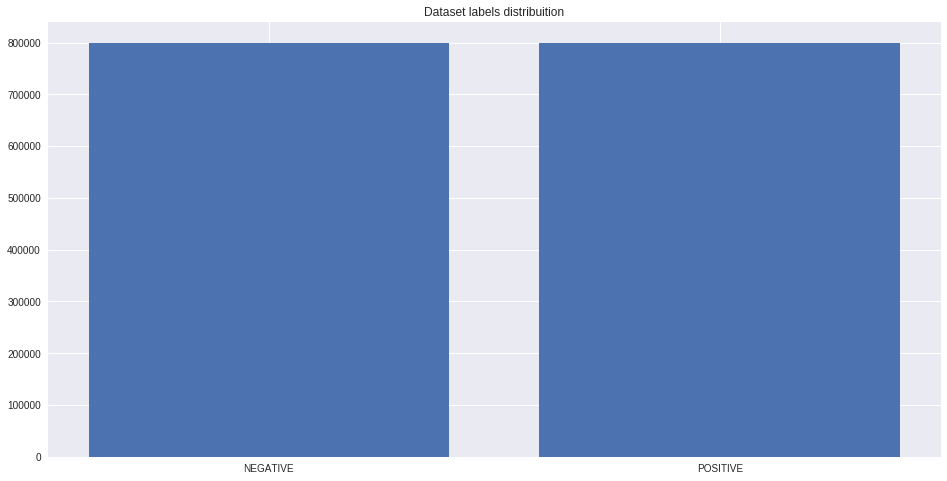

In [27]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

## Pre-Process dataset

In [0]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [0]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [30]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 51.8 s, sys: 215 ms, total: 52 s
Wall time: 52.1 s


## Split train and test

In [31]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


## Word2Vec

In [32]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 3.26 s, sys: 328 ms, total: 3.59 s
Wall time: 3.59 s


In [0]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [34]:
w2v_model.build_vocab(documents)

2019-04-02 13:44:01,713 : INFO : collecting all words and their counts
2019-04-02 13:44:01,716 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-04-02 13:44:01,753 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2019-04-02 13:44:01,780 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2019-04-02 13:44:01,807 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2019-04-02 13:44:01,839 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2019-04-02 13:44:01,869 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2019-04-02 13:44:01,898 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2019-04-02 13:44:01,926 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2019-04-02 13:44:01,956 : INFO : PROGRESS: at s

In [35]:
words  = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [36]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2019-04-02 13:44:06,517 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2019-04-02 13:44:07,607 : INFO : EPOCH 1 - PROGRESS: at 4.01% examples, 310171 words/s, in_qsize 16, out_qsize 0
2019-04-02 13:44:08,639 : INFO : EPOCH 1 - PROGRESS: at 8.58% examples, 340042 words/s, in_qsize 16, out_qsize 0
2019-04-02 13:44:09,671 : INFO : EPOCH 1 - PROGRESS: at 12.93% examples, 339182 words/s, in_qsize 15, out_qsize 0
2019-04-02 13:44:10,687 : INFO : EPOCH 1 - PROGRESS: at 17.78% examples, 352688 words/s, in_qsize 15, out_qsize 0
2019-04-02 13:44:11,691 : INFO : EPOCH 1 - PROGRESS: at 22.11% examples, 353117 words/s, in_qsize 15, out_qsize 0
2019-04-02 13:44:12,747 : INFO : EPOCH 1 - PROGRESS: at 26.45% examples, 350452 words/s, in_qsize 15, out_qsize 0
2019-04-02 13:44:13,749 : INFO : EPOCH 1 - PROGRESS: at 30.78% examples, 351191 words/s, in_qsize 14, out_qsize 1
2019-04-02 13:44:14,767 : INFO : EPOCH 1 - PROGRESS: a

CPU times: user 23min 2s, sys: 4.91 s, total: 23min 7s
Wall time: 11min 50s


(263122939, 295270528)

In [37]:
w2v_model.most_similar("love")

2019-04-02 13:55:57,432 : INFO : precomputing L2-norms of word weight vectors


[('loves', 0.5760223865509033),
 ('luv', 0.559371829032898),
 ('loved', 0.5453555583953857),
 ('adore', 0.5131479501724243),
 ('amazing', 0.5073188543319702),
 ('looove', 0.48991724848747253),
 ('loveee', 0.47647997736930847),
 ('awesome', 0.464517205953598),
 ('loooove', 0.4491255581378937),
 ('lovee', 0.437805712223053)]

## Tokenize Text

In [38]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 25 s, sys: 158 ms, total: 25.1 s
Wall time: 25.1 s


In [39]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 35.7 s, sys: 988 ms, total: 36.7 s
Wall time: 36.7 s


In [40]:
x_train

array([[     0,      0,      0, ...,    712,    118,  24590],
       [     0,      0,      0, ...,    452,    378,  32447],
       [     0,      0,      0, ...,   2048,      4,   5487],
       ...,
       [     0,      0,      0, ...,    661,   4246, 290416],
       [     0,      0,      0, ...,     12,    477,    957],
       [     0,      0,      0, ...,      9,    502,    268]], dtype=int32)

In [41]:
df_train.target[0:10]

1374558    POSITIVE
1389115    POSITIVE
1137831    POSITIVE
790714     NEGATIVE
1117911    POSITIVE
1077663    POSITIVE
1253991    POSITIVE
1535242    POSITIVE
1396460    POSITIVE
1178954    POSITIVE
Name: target, dtype: object

## Label Encoder

In [42]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [43]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [44]:
y_train

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [45]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [46]:
y_train[:20]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0]])

## Embedding layer

In [47]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [0]:
combined_embedding_vector_length= embedding_matrix.shape[1]

In [0]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

## Build Model

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [51]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


2019-04-02 13:57:01,165 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-04-02 13:57:03,832 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


**Compile model**

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

**Callbacks**

In [0]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

**Train**

In [54]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.


2019-04-02 13:57:04,459 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 1020s 885us/step - loss: 0.5069 - acc: 0.7484 - val_loss: 0.4678 - val_acc: 0.7782
Epoch 2/8
1152000/1152000 [==============================] - 1019s 885us/step - loss: 0.4806 - acc: 0.7664 - val_loss: 0.4602 - val_acc: 0.7831
Epoch 3/8
1152000/1152000 [==============================] - 1019s 884us/step - loss: 0.4736 - acc: 0.7711 - val_loss: 0.4553 - val_acc: 0.7852
Epoch 4/8
1152000/1152000 [==============================] - 1018s 883us/step - loss: 0.4692 - acc: 0.7740 - val_loss: 0.4522 - val_acc: 0.7874
Epoch 5/8
1152000/1152000 [==============================] - 1020s 885us/step - loss: 0.4671 - acc: 0.7753 - val_loss: 0.4497 - val_acc: 0.7875
Epoch 6/8
1152000/1152000 [==============================] - 1021s 886us/step - loss: 0.4647 - acc: 0.7766 - val_loss: 0.4492 - val_acc: 0.7879
Epoch 7/8
1152000/1152000 [==============================] - 1028s 892us/step - los

In [55]:
 %%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 112s 349us/step

ACCURACY: 0.7902
LOSS: 0.4477609361171722
CPU times: user 2min 9s, sys: 11.2 s, total: 2min 21s
Wall time: 1min 51s


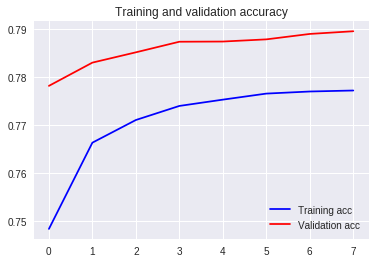

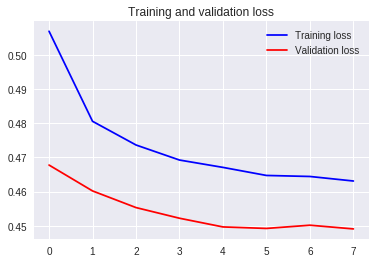

In [56]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

**Predict**

In [0]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE


In [0]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [59]:
predict("I love the music")

{'elapsed_time': 0.3865649700164795,
 'label': 'POSITIVE',
 'score': 0.980268657207489}

In [60]:
predict("I hate the rain")

{'elapsed_time': 0.2435457706451416,
 'label': 'NEGATIVE',
 'score': 0.010711903683841228}

In [61]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.23833155632019043,
 'label': 'NEGATIVE',
 'score': 0.31205546855926514}

**Confusion Matrix**

In [62]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=1000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

320000/320000 [==============================] - 114s 355us/step
CPU times: user 2min 13s, sys: 11.3 s, total: 2min 25s
Wall time: 1min 54s
